## Visualisation
This code uses the output from MWATS_average_SQL and provides basic visualisation functionality. 

In [12]:
import plots as pl
import pandas as pd
import matplotlib.pyplot as plt 
import aplpy 
import os
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Load the data
stats = pd.read_feather('stats_table.fth')
filtered_raw_data = pd.read_feather('data.fth')
filtered_raw_avg_data = pd.read_feather('avg_data.fth')
neighbours = pd.read_feather('neighbours.fth')

/Users/134393/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [ ]:
# Generic function for plotting light-curves and stats.
def plot_lc(source):
    all = filtered_raw_data[filtered_raw_data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(7, 8))
    plt.subplot(2,1,1)
    f = list(all.raw_peak_flux)
    s_stats = stats[stats.source_id == source]
    plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
    #plt.title(str(source)+' RA='+str(s_stats.ra)+' DEC='+str(s_stats.dec))
    plt.plot(list(f), 'k.', label='Flux')
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    # Non-averaged
    plt.subplot(2,1,2)
    plt.plot(all.jd, all.raw_peak_flux, 'k.', label='Flux')
    ts = []
    ys = []
    for t in all.jd:
        sli = stats[stats.source_id == source]
        y = (sli.grad * t) + sli.y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'k-.', label='$\\nabla_{S} = $'+str( round(float(sli.sig),2) ))
        
    # Averaged 
    avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == source]
    plt.errorbar(avg.mean_jd, avg.median_flux, avg.std_flux, fmt='ro', label="Median flux", markersize=10)
    ts = []
    ys = []
    for t in avg.mean_jd:
        sli = stats[stats.source_id == source]
        y = (sli.avg_grad * t) + sli.avg_y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'r-.', label='Median $\\nabla_{S} = $'+str( round(float(sli.avg_sig),2) ))
    #plt.ylim(np.mean(f)*0.8, np.mean(f)*1.2)
    plt.xlabel('Time (JD)')
    plt.ylabel('Flux (Jy)')
    plt.savefig('thumbs/'+str(source)+'_Avg_LC.jpg')
    plt.legend()
    plt.close

In [ ]:
def get_image(source_id):
    exists = os.path.isfile('thumbs/'+str(source_id)+'.jpg')
    if not exists:
        # Select random image
        plt.figure(figsize=[10,12])
        image = filtered_raw_data[filtered_raw_data.source_id == source_id].image.sample(1).values[0]
        s_stats = stats[stats.source_id == source_id]
        grid = True
        size=(600, 600)
        dpi = 40
        figure = aplpy.FITSFigure('/Volumes/BEL27A-BKP01/MWATS/'+image, dimensions=[0,1], slices=[0,0], auto_refresh=False, dpi = dpi, figsize = (size[0] / float(dpi), size[1] / float(dpi)))
        ra = s_stats.ra.values[0]
        dec = s_stats.dec.values[0]
        circle_size = 1.0 # 1 degree circle
        figure.recenter(ra, dec, radius=1.0, width=2.0, height=2.0)
        #figure.recenter(ra, dec, circle_size) 
        if grid:
            try:
                figure.add_grid()
            except Exception as e:
                logging.warn("APLpy error adding grid to image: {0}".format(e))
        # Adjust the axis labels, otherwise they overlap
        # If the image is less than two arc minutes across, show seconds on the tick labels
    
        image_radius = circle_size
        if image_radius < 1.0 / 60.0 * 2:
                figure.tick_labels.set_xformat("hh:mm:ss")
                figure.tick_labels.set_yformat("dd:mm:ss")
        else:
                figure.tick_labels.set_xformat("hh:mm")
                figure.tick_labels.set_yformat("dd:mm")

        figure.tick_labels.set_xformat("dd:mm")
        figure.tick_labels.set_yformat("dd:mm")
        figure.show_grayscale(pmin=5.0, pmax=99.5, invert=False)
        figure.add_colorbar()
        # Show locations of the neighbours
        figure.show_rectangles(ra, dec, 0.1, 0.1, edgecolor='k', linewidth=2.0)
        n = neighbours[neighbours.source_id == source_id]
        for num in range(5):
            if num == 0:
               neigh = n.n_id1.values[0]
               nra  =  n.n_id1_ra.values[0]
               ndec =  n.n_id1_dec.values[0]
               colour = 'm'
            if num == 1:
               neigh = n.n_id2.values[0]
               nra  =  n.n_id2_ra.values[0]
               ndec =  n.n_id2_dec.values[0]
               colour = 'y'
            if num == 2:
               neigh = n.n_id3.values[0]
               nra  =  n.n_id3_ra.values[0]
               ndec =  n.n_id3_dec.values[0]
               colour = 'c'
            if num == 3:
               neigh = n.n_id4.values[0]
               nra  =  n.n_id4_ra.values[0]
               ndec =  n.n_id4_dec.values[0]
               colour = 'b'
            if num == 4:
               neigh = n.n_id5.values[0]
               nra  =  n.n_id5_ra.values[0]
               ndec =  n.n_id5_dec.values[0]
               colour = 'r'
            #n_stats = stats[stats.source_id == neigh]
            #print(n_stats)
            figure.show_ellipses(nra, ndec, 0.1, 0.1, edgecolor=colour, linewidth=2.0)
        figure.save('thumbs/'+str(source_id)+'.jpg')
        figure.close()

In [ ]:
def plot_n_lc(source):
    plt.figure(figsize=[8,6])
    #plt.subplot(2,1,1)
    gs = gridspec.GridSpec(3, 2)
    n = neighbours[neighbours.source_id == source]
    for num in range(5):
        if num == 0:
               neigh = n.n_id1.values[0]
               colour = 'm'
        if num == 1:
               neigh = n.n_id2.values[0]
               colour = 'y'
        if num == 2:
               neigh = n.n_id3.values[0]
               colour = 'c'
        if num == 3:
               neigh = n.n_id4.values[0]
               colour = 'b'
        if num == 4:
               neigh = n.n_id5.values[0]
               colour = 'r'
        #plt.subplot2grid((3, 2), (num, 0))    
        plt.subplot(gs[num])    
        #plt.subplot(3,2,num+1)
        s_stats = stats[stats.source_id == source]
        #plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
        main = filtered_raw_data[filtered_raw_data.source_id == source]
        main = main.sort_values(by='jd')
        n = neighbours[neighbours.source_id == source]
        n_data = filtered_raw_data[filtered_raw_data.source_id == neigh]
        n_data = n_data.sort_values(by='jd')

        main = main.set_index('time')
        n_data = n_data.set_index('time')

        result = pd.concat([main, n_data])
        result = result.sort_values(by='time')

        image_ids = list(result.image_id)

        count = 0
        counts = []
        counts.append(count)
        for i in range(len(image_ids)-1):
            if image_ids[i+1]-image_ids[i] == 0:
               count = count
            else: 
               count = count + 1
            counts.append(count)

        result['counts'] = counts

        p1 = result[result.source_id == source] 
        p2 = result[result.source_id == neigh]
    
        plt.plot(p2.counts, p2.raw_peak_flux, color=colour, markersize=5, marker='.', label='Neighbour', alpha=0.5)
        plt.plot(p1.counts, p1.raw_peak_flux, 'ko-.', label='Main', alpha=0.5)

        plt.ylabel('Flux (Jy)')
        plt.xlabel('Image sequence (N)')
        #plt.legend()
    
    # Plot the gain
    plt.subplot(gs[5])
    plt.plot(list(main.Gain), 'ko', alpha=0.5)
    plt.ylabel('Gain')
    plt.xlabel('Image sequence (N)')
    plt.tight_layout()
    plt.savefig('thumbs/'+str(source)+'_LCS.jpg')
    plt.close()


### View interesting light-curves:

In [ ]:
avg_sig_cut = 0.0
avg_flux_cut = 0.25
avg_Mod_cut = 20.0
Mod_cut = 0.0

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut) ]

len(interesting) # How many objects we have in our cut.

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.461e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.638e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.289e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.809e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.011e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.816e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.163e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.493e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.095e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.230e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.539e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.992e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.273e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.963e+00 [aplpy.core]

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.288e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.478e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.755e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.084e-01 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.293e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.699e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.934e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.627e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.723e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.156e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.345e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.360e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.541e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.057e+00 [aplpy.core]

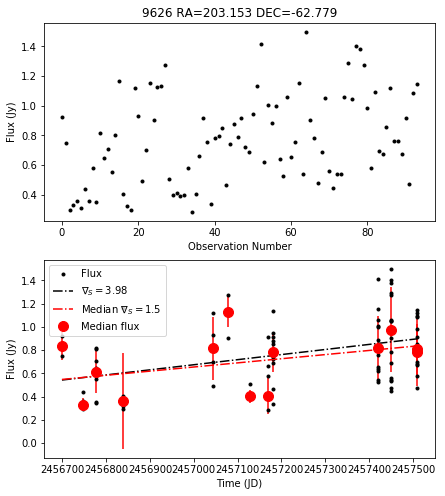

<Figure size 720x864 with 0 Axes>

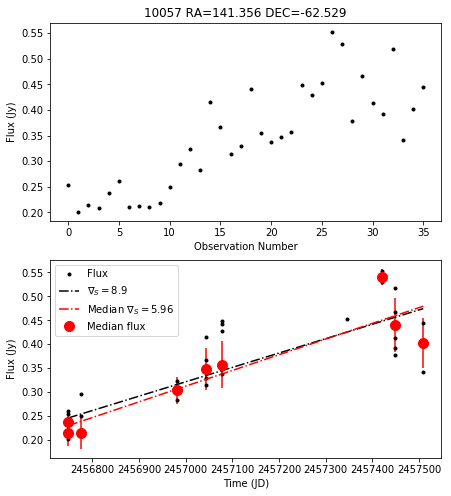

<Figure size 720x864 with 0 Axes>

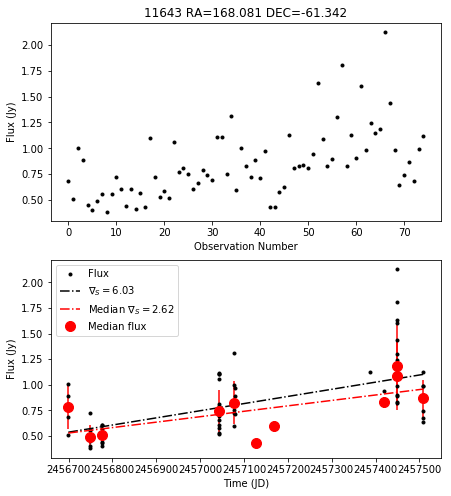

<Figure size 720x864 with 0 Axes>

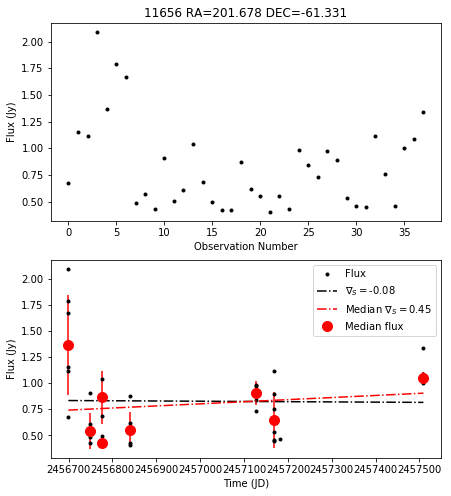

<Figure size 720x864 with 0 Axes>

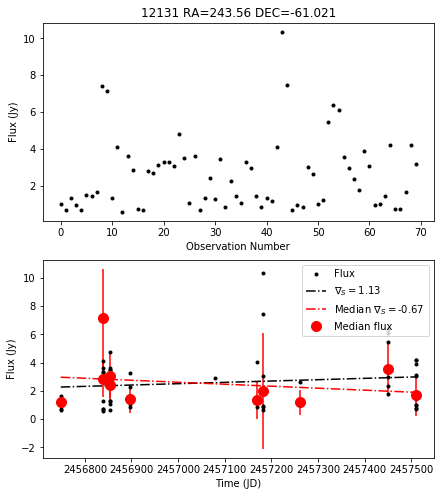

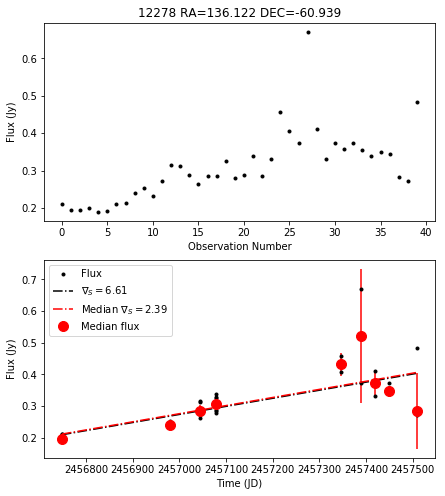

<Figure size 720x864 with 0 Axes>

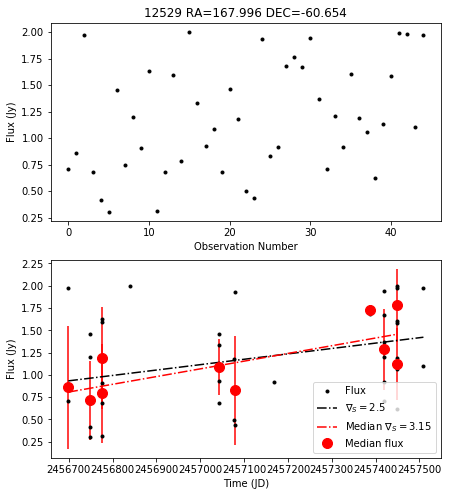

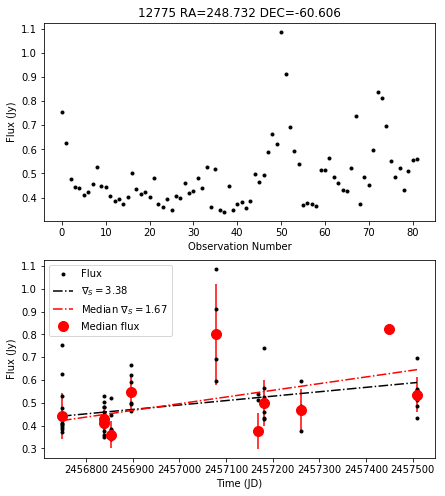

<Figure size 720x864 with 0 Axes>

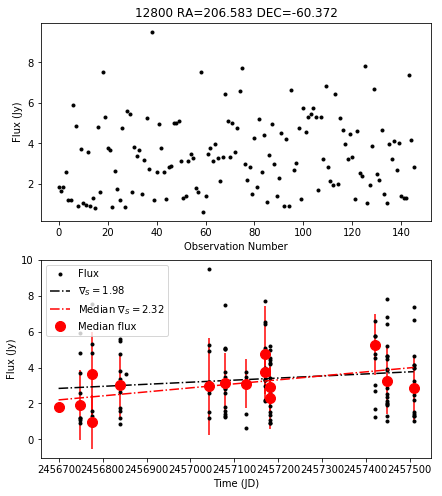

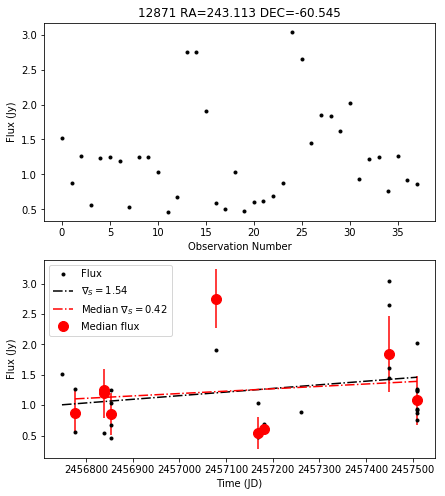

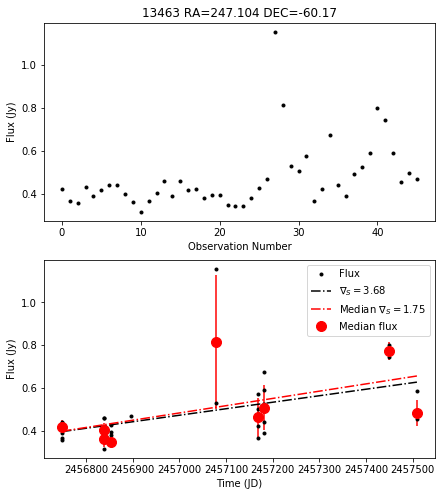

<Figure size 720x864 with 0 Axes>

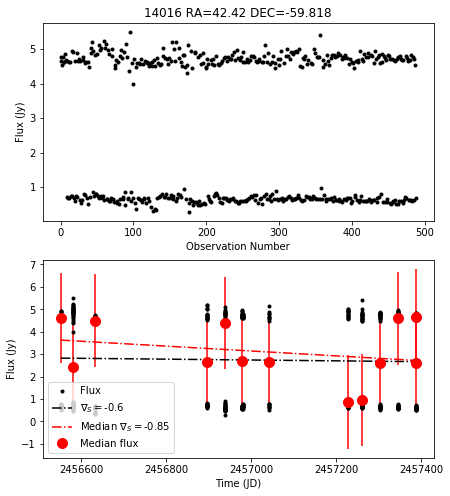

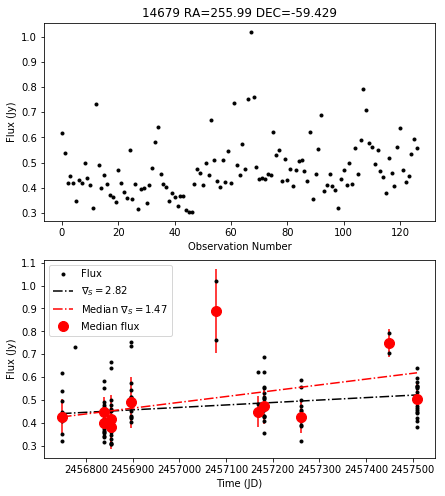

<Figure size 720x864 with 0 Axes>

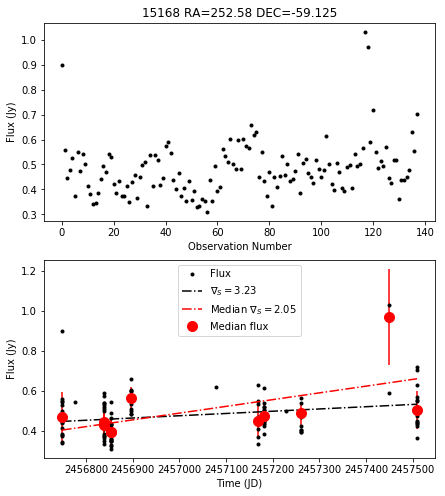

<Figure size 720x864 with 0 Axes>

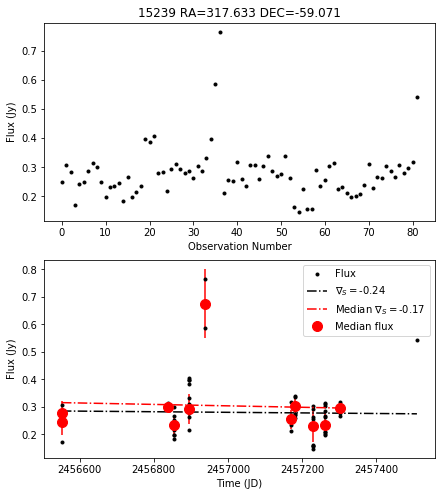

<Figure size 720x864 with 0 Axes>

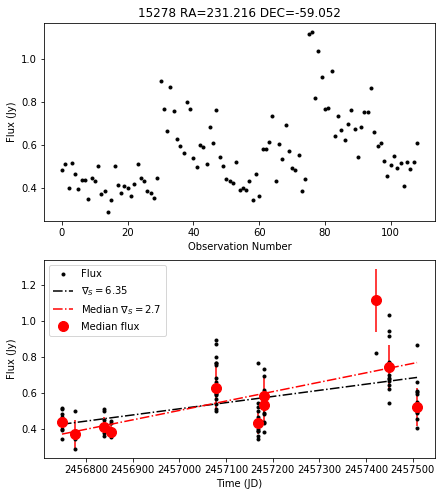

<Figure size 720x864 with 0 Axes>

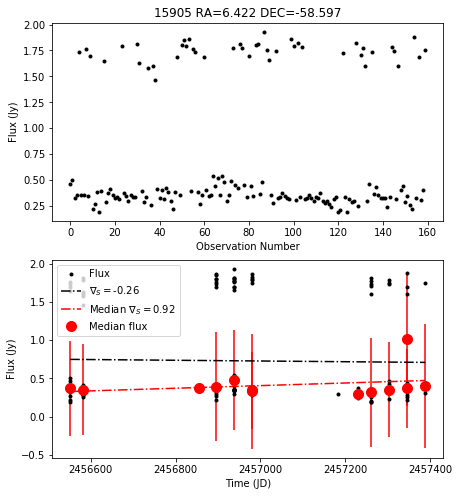

<Figure size 720x864 with 0 Axes>

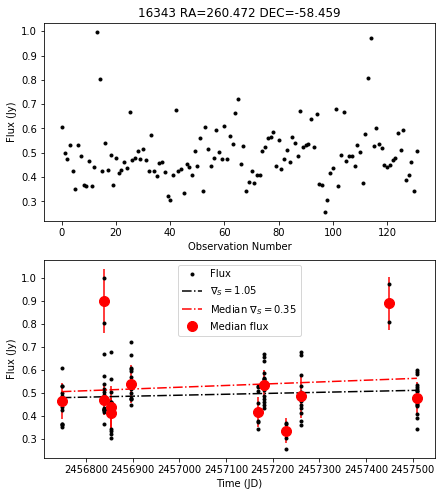

<Figure size 720x864 with 0 Axes>

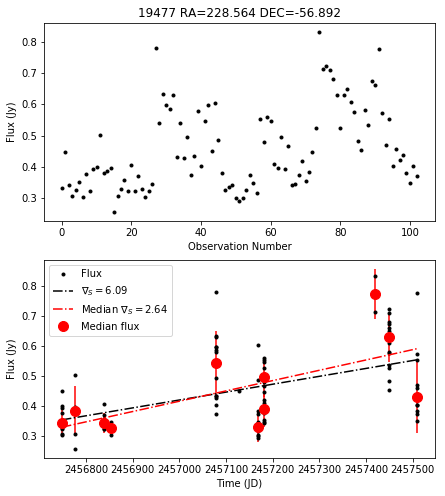

<Figure size 720x864 with 0 Axes>

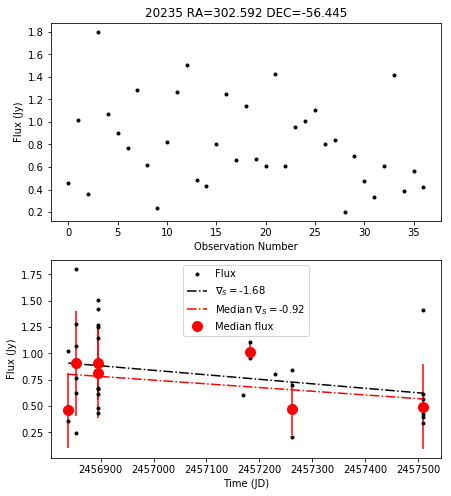

<Figure size 720x864 with 0 Axes>

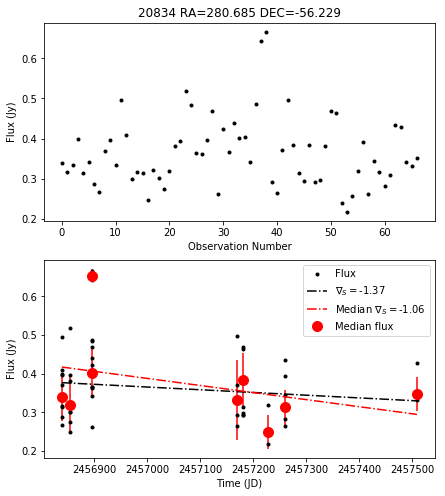

<Figure size 720x864 with 0 Axes>

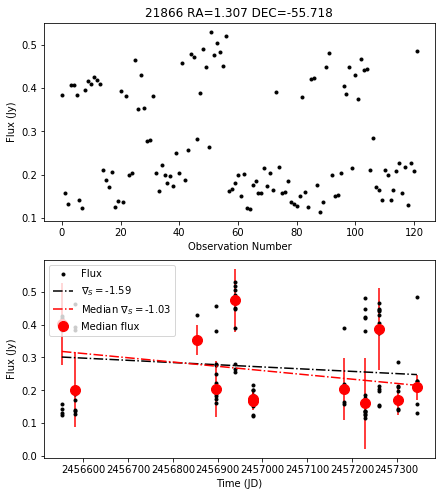

<Figure size 720x864 with 0 Axes>

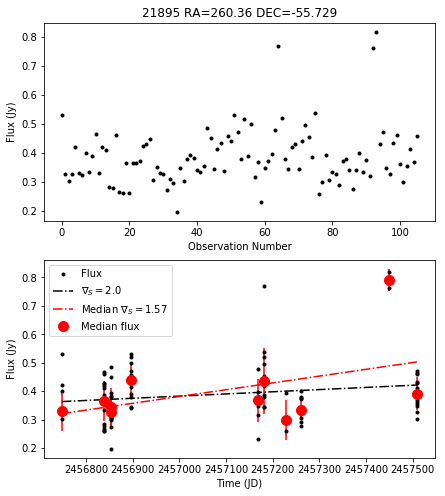

<Figure size 720x864 with 0 Axes>

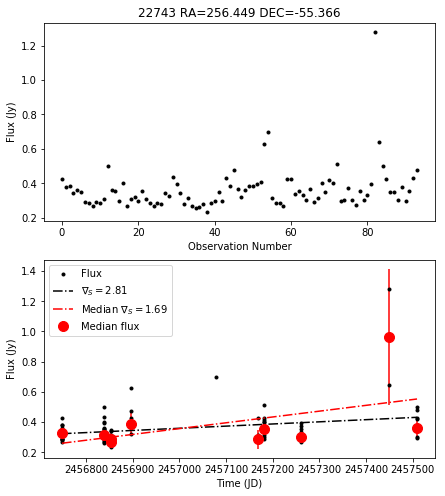

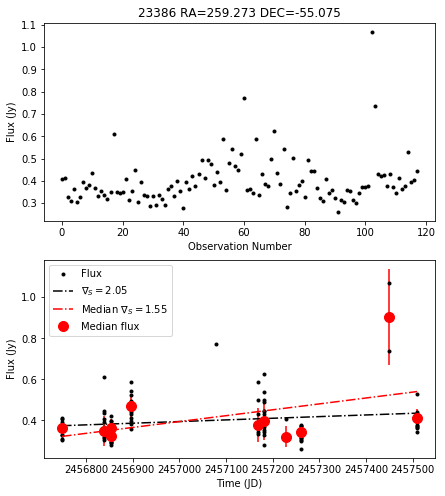

<Figure size 720x864 with 0 Axes>

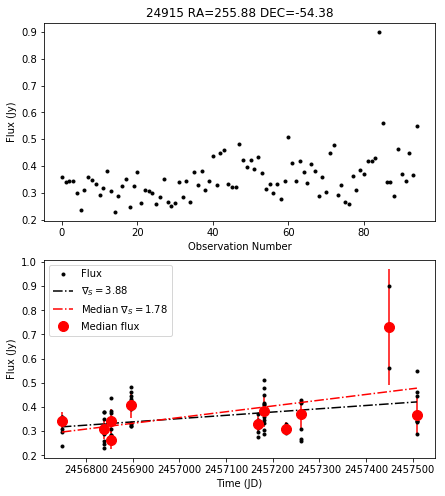

<Figure size 720x864 with 0 Axes>

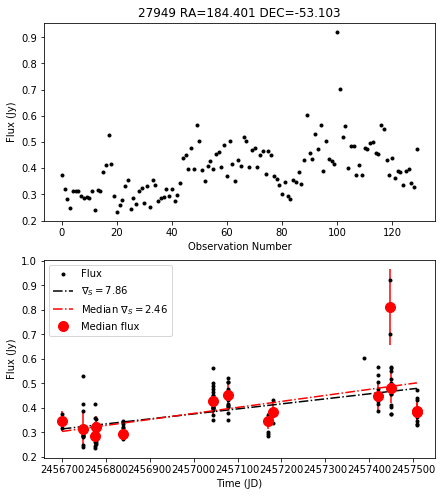

<Figure size 720x864 with 0 Axes>

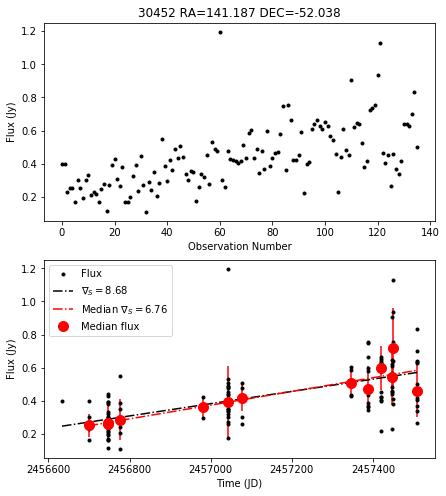

<Figure size 720x864 with 0 Axes>

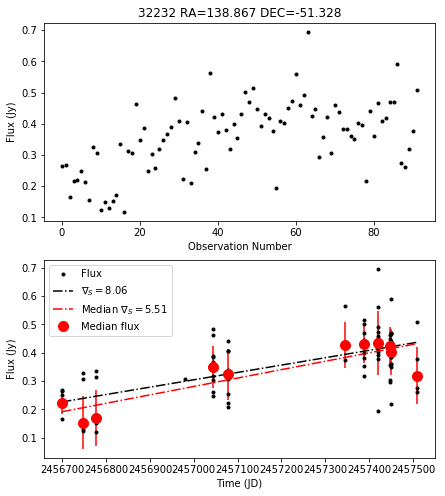

<Figure size 720x864 with 0 Axes>

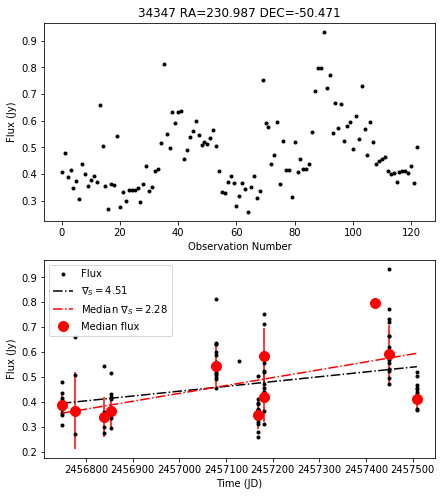

<Figure size 720x864 with 0 Axes>

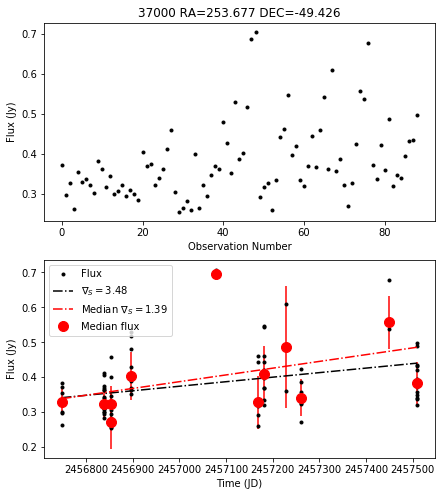

<Figure size 720x864 with 0 Axes>

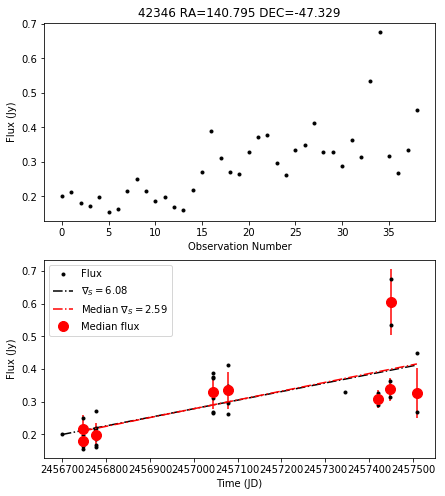

<Figure size 720x864 with 0 Axes>

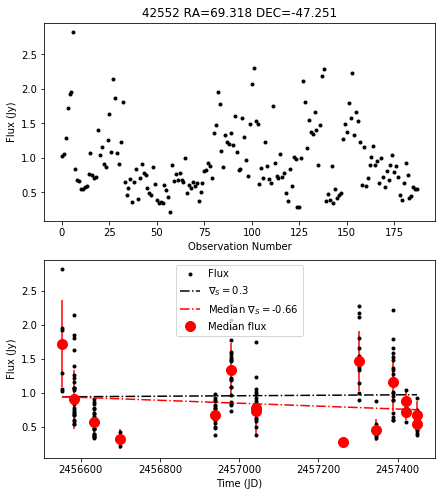

<Figure size 720x864 with 0 Axes>

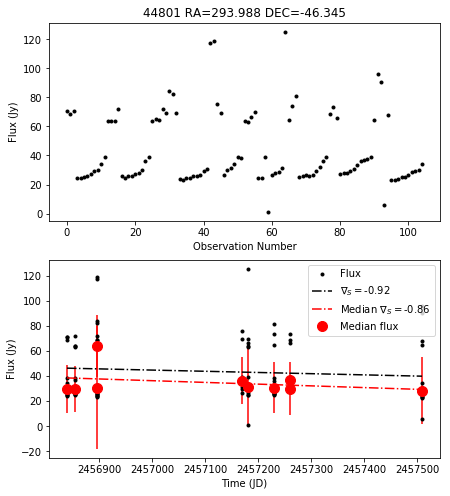

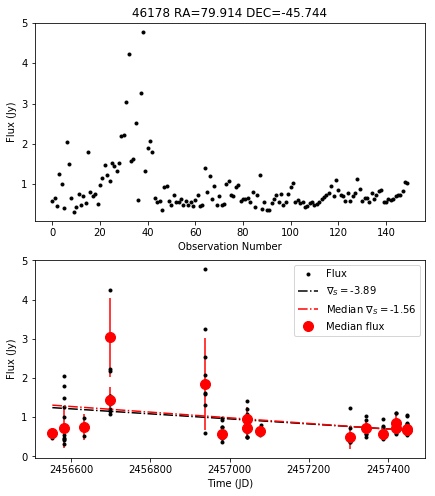

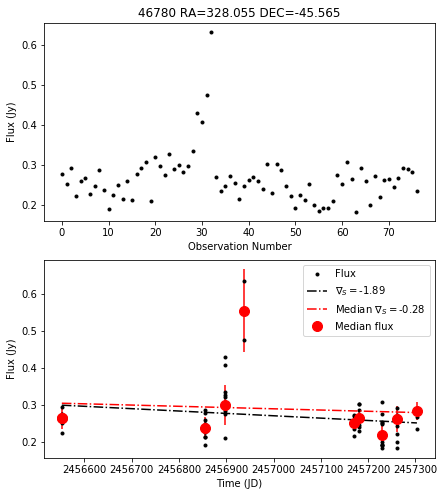

<Figure size 720x864 with 0 Axes>

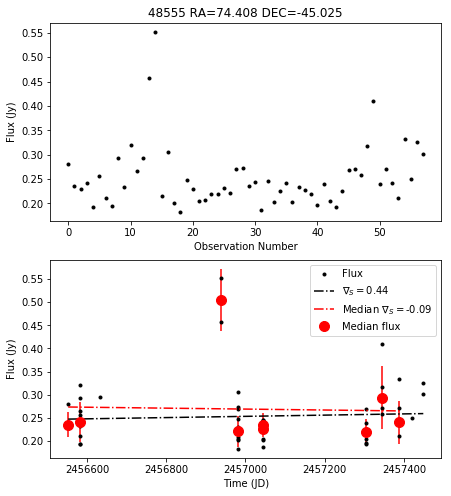

<Figure size 720x864 with 0 Axes>

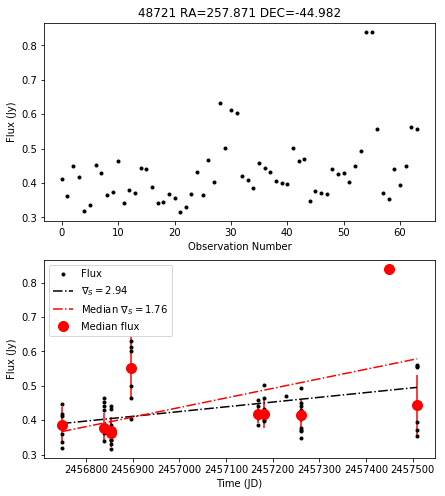

<Figure size 720x864 with 0 Axes>

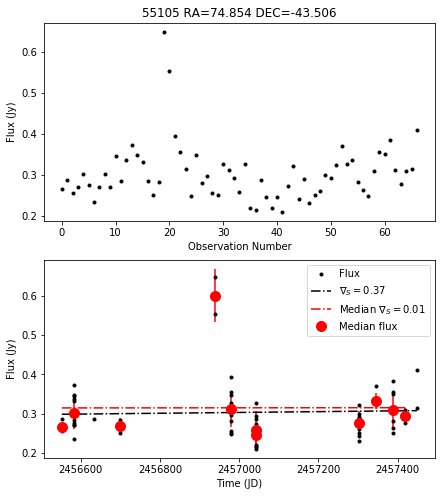

<Figure size 720x864 with 0 Axes>

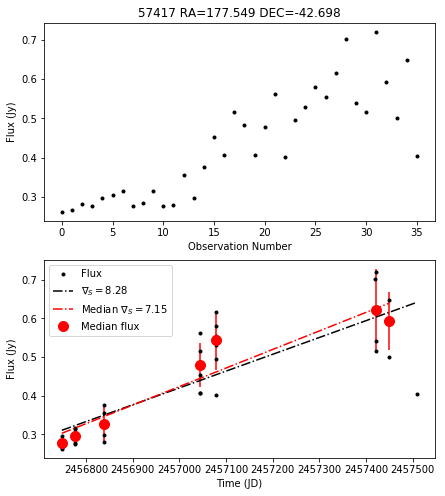

<Figure size 720x864 with 0 Axes>

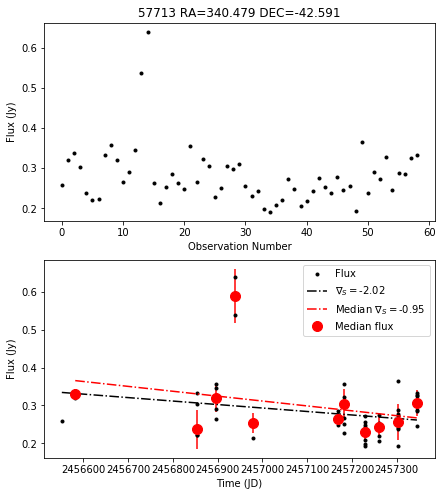

<Figure size 720x864 with 0 Axes>

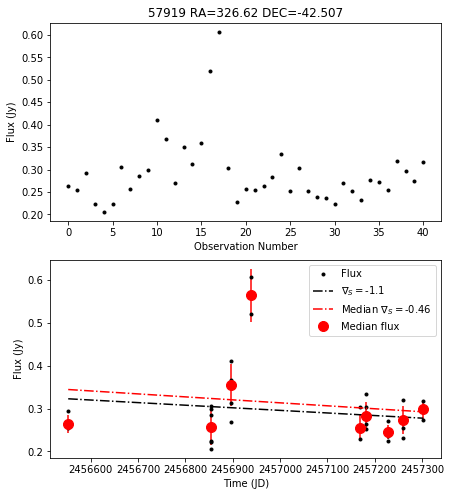

<Figure size 720x864 with 0 Axes>

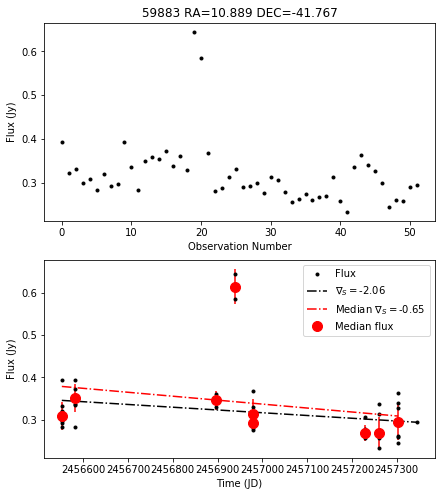

<Figure size 720x864 with 0 Axes>

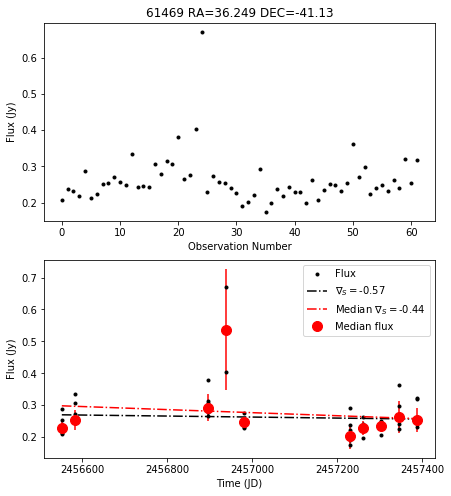

<Figure size 720x864 with 0 Axes>

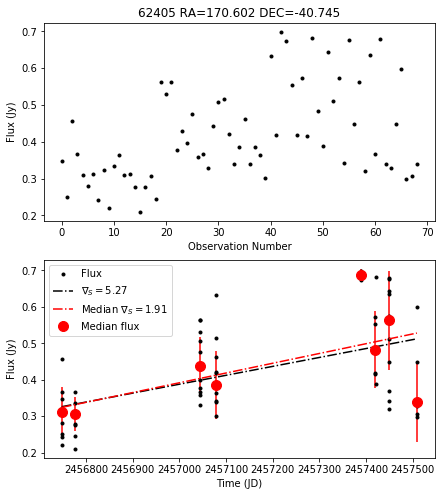

<Figure size 720x864 with 0 Axes>

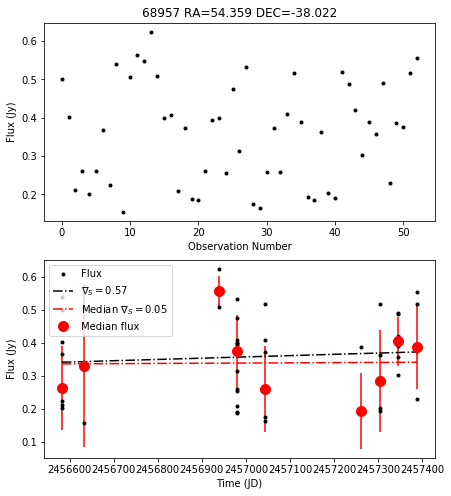

<Figure size 720x864 with 0 Axes>

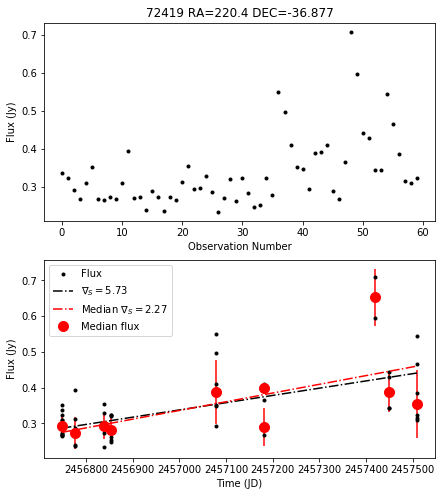

<Figure size 720x864 with 0 Axes>

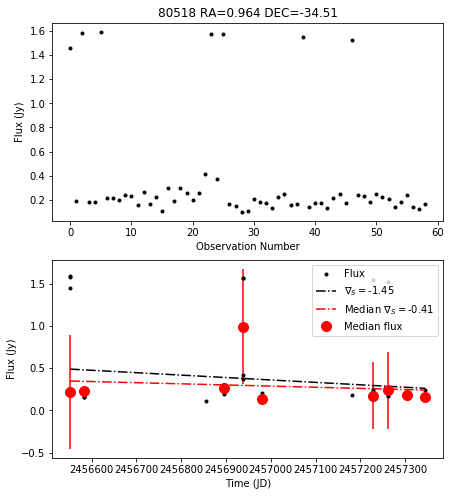

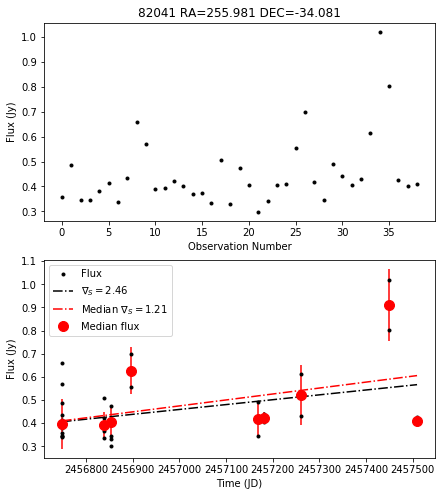

<Figure size 720x864 with 0 Axes>

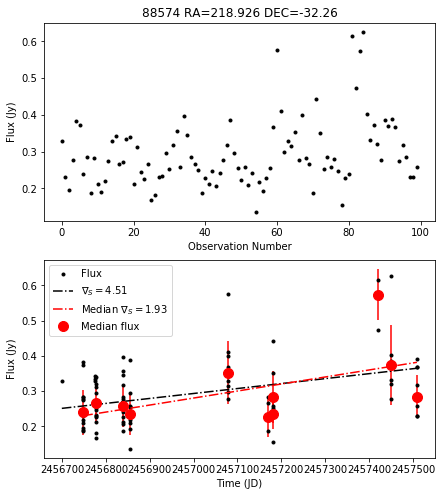

<Figure size 720x864 with 0 Axes>

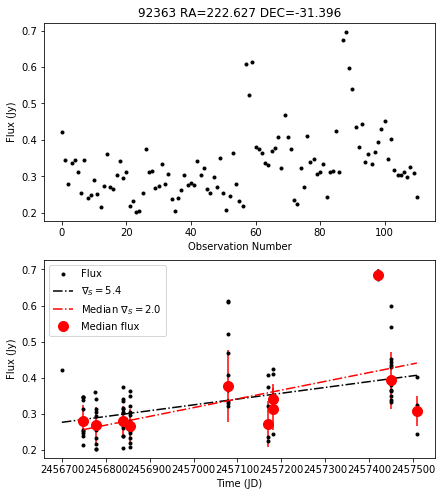

<Figure size 720x864 with 0 Axes>

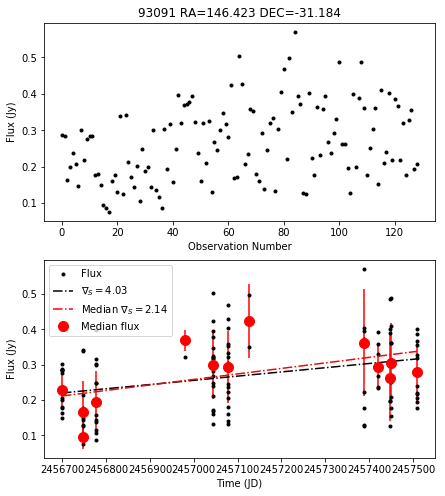

<Figure size 720x864 with 0 Axes>

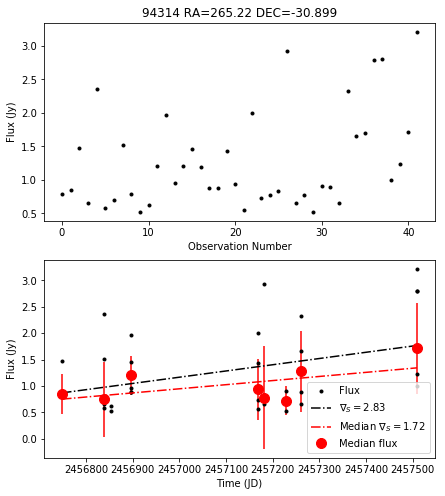

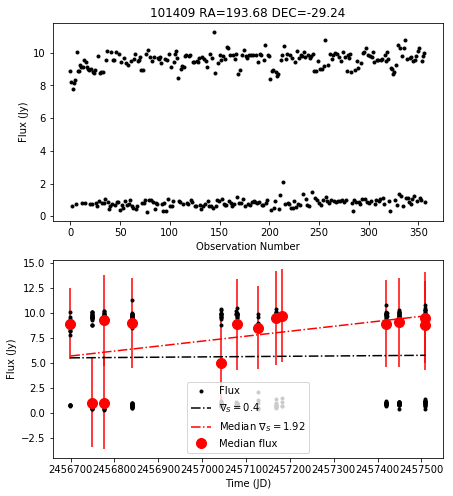

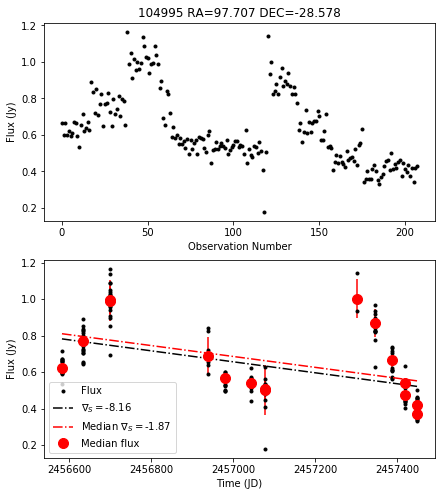

<Figure size 720x864 with 0 Axes>

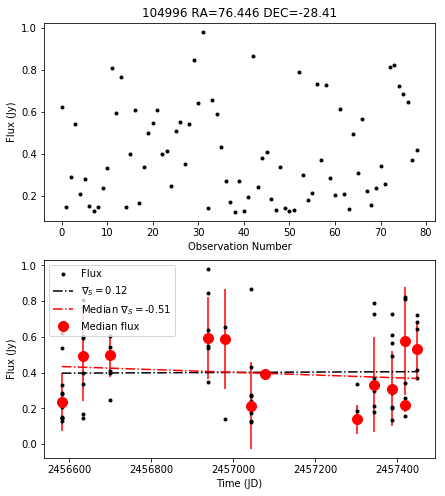

<Figure size 720x864 with 0 Axes>

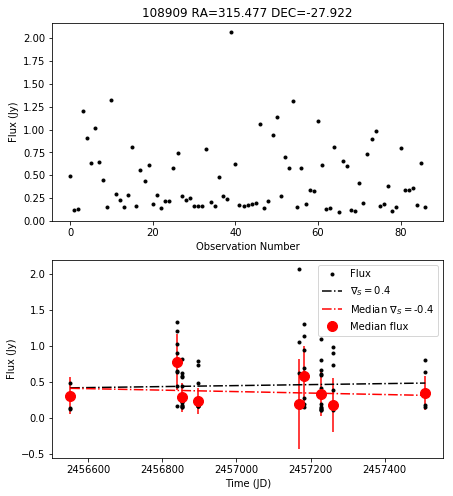

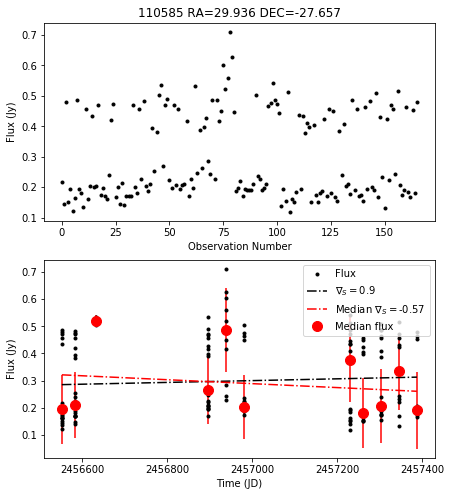

<Figure size 720x864 with 0 Axes>

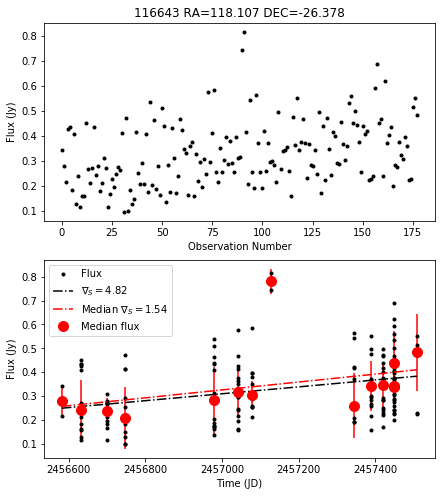

<Figure size 720x864 with 0 Axes>

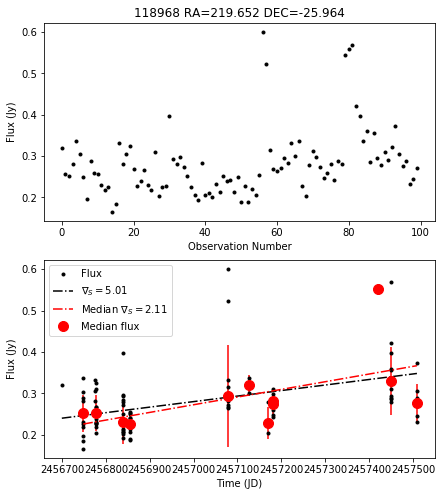

<Figure size 720x864 with 0 Axes>

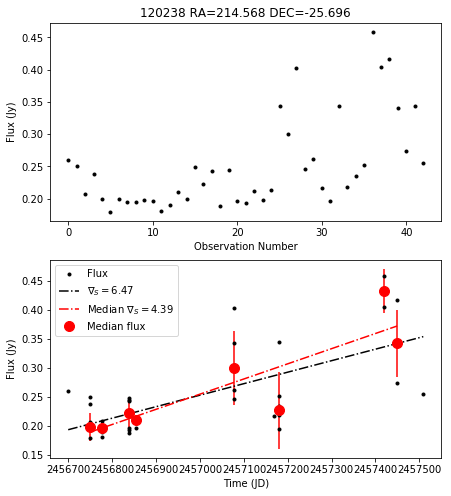

<Figure size 720x864 with 0 Axes>

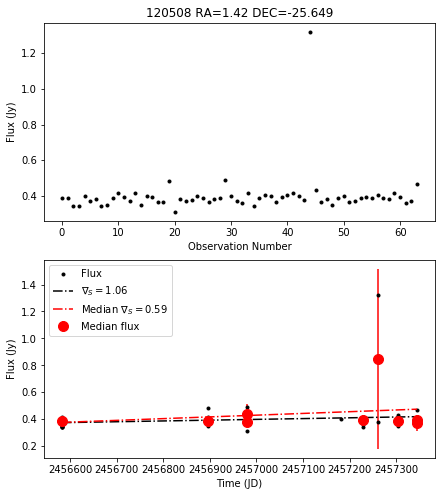

<Figure size 720x864 with 0 Axes>

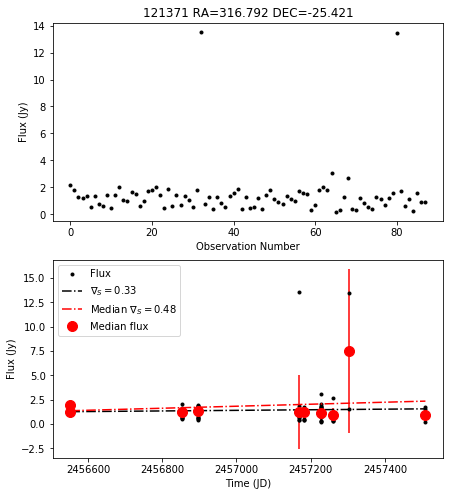

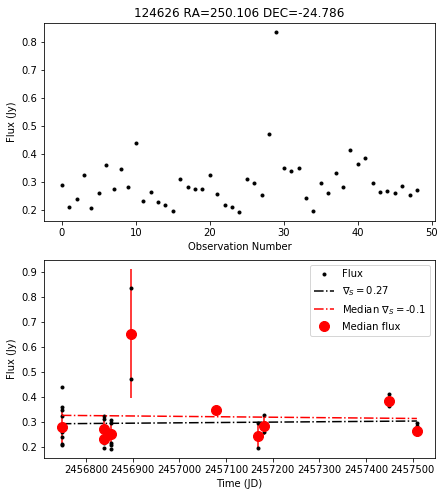

<Figure size 720x864 with 0 Axes>

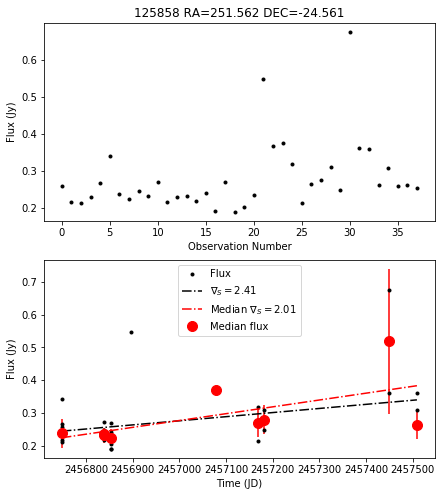

<Figure size 720x864 with 0 Axes>

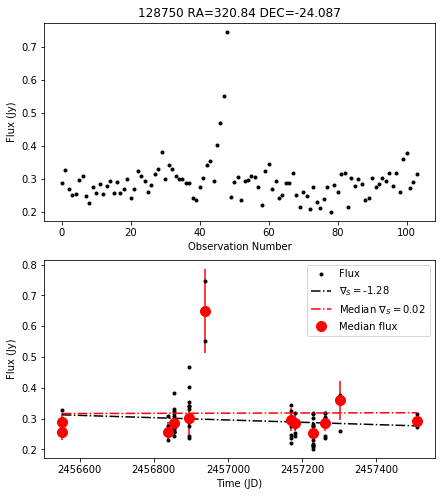

<Figure size 720x864 with 0 Axes>

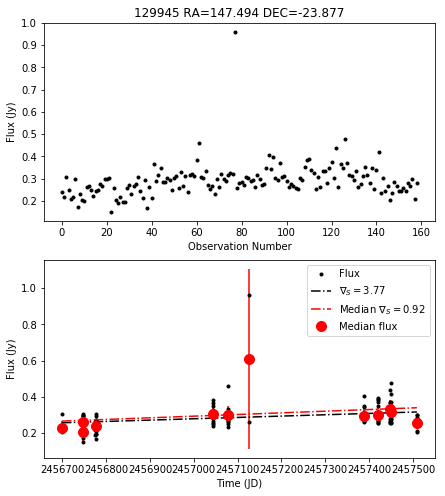

<Figure size 720x864 with 0 Axes>

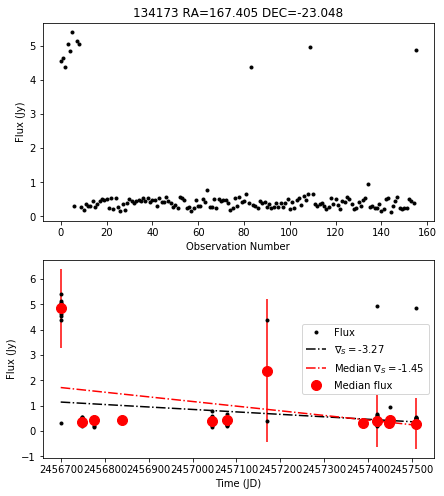

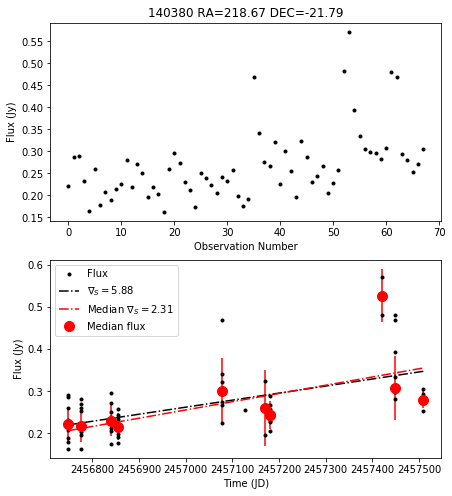

<Figure size 720x864 with 0 Axes>

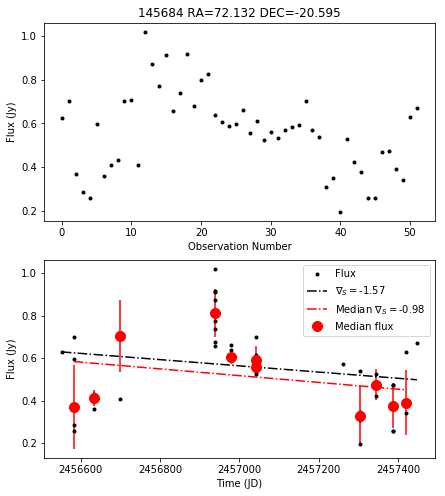

<Figure size 720x864 with 0 Axes>

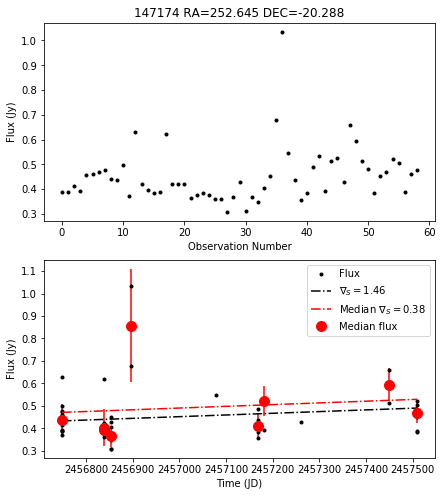

<Figure size 720x864 with 0 Axes>

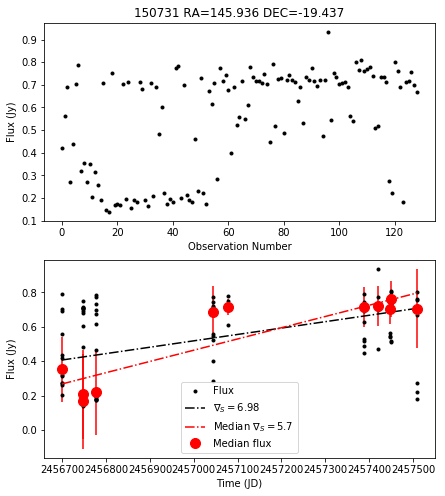

<Figure size 720x864 with 0 Axes>

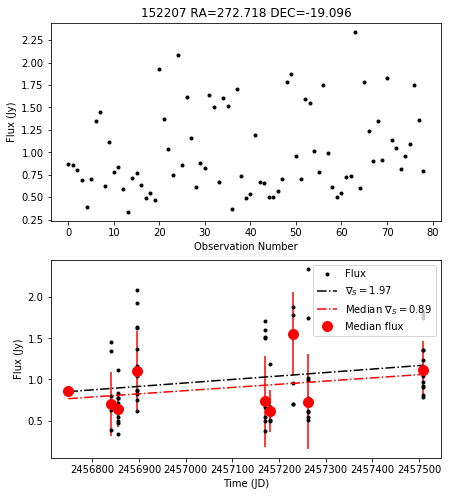

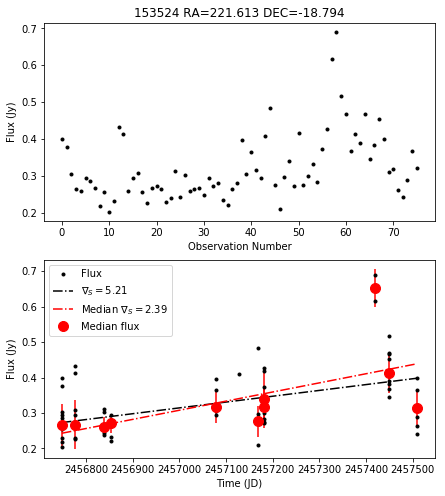

<Figure size 720x864 with 0 Axes>

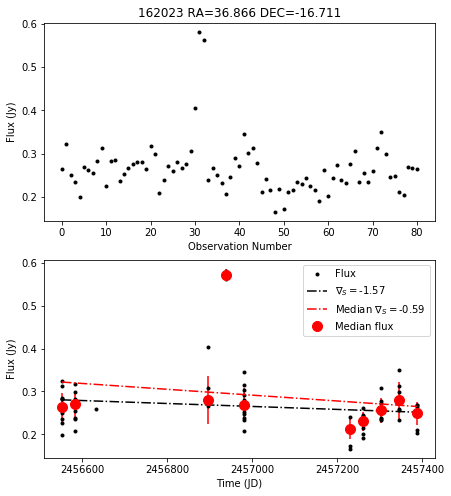

<Figure size 720x864 with 0 Axes>

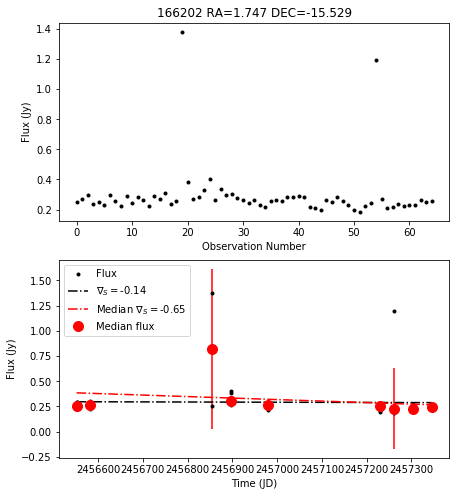

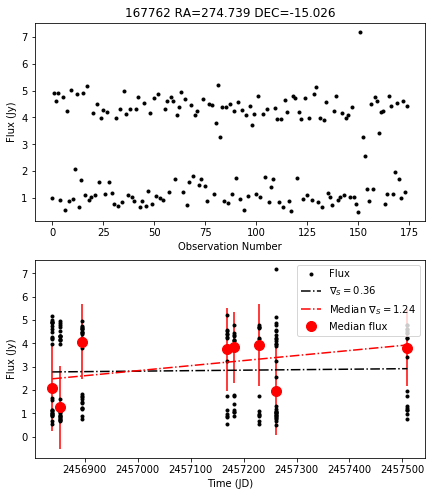

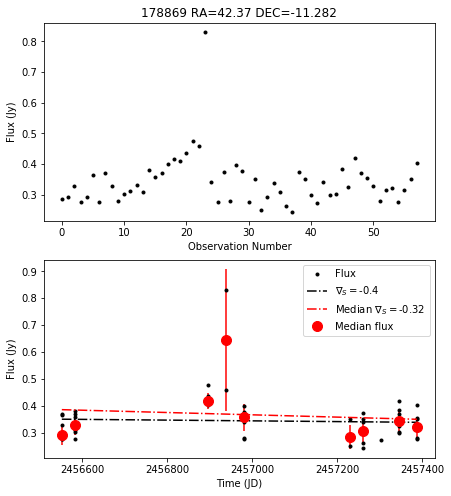

<Figure size 720x864 with 0 Axes>

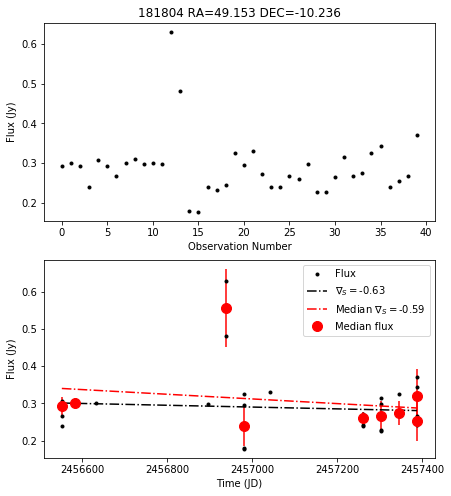

<Figure size 720x864 with 0 Axes>

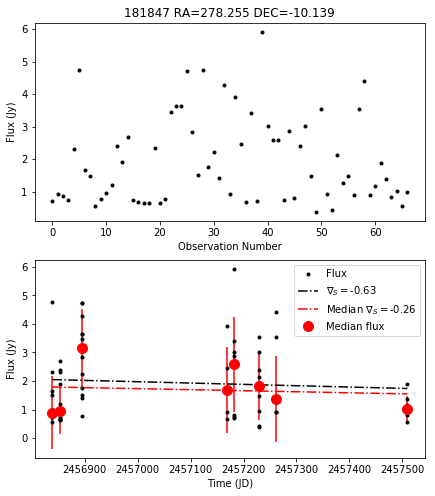

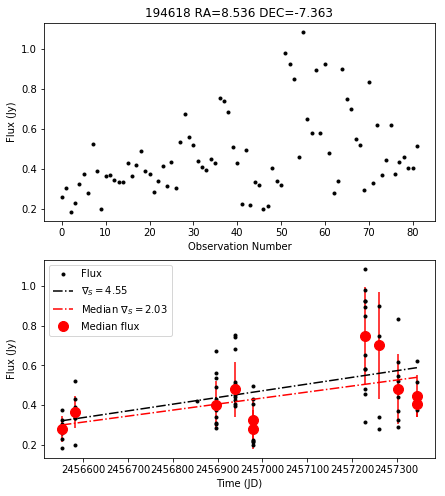

<Figure size 720x864 with 0 Axes>

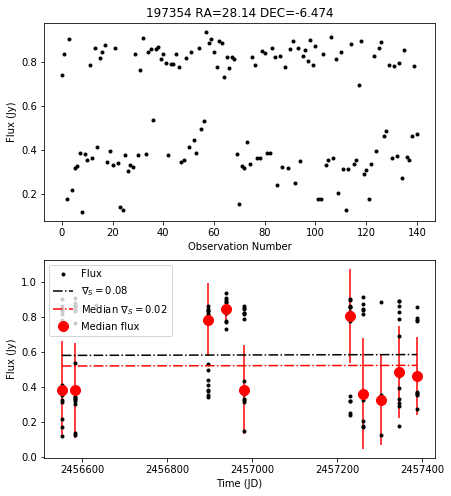

<Figure size 720x864 with 0 Axes>

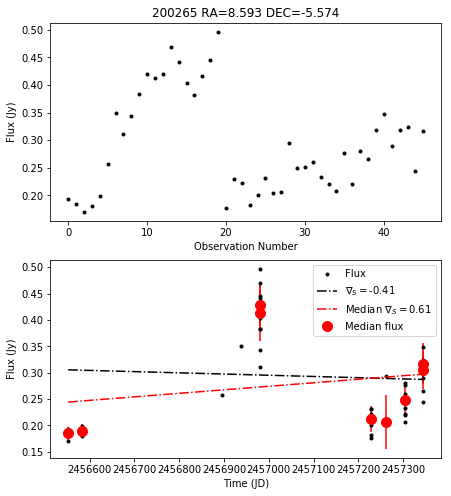

<Figure size 720x864 with 0 Axes>

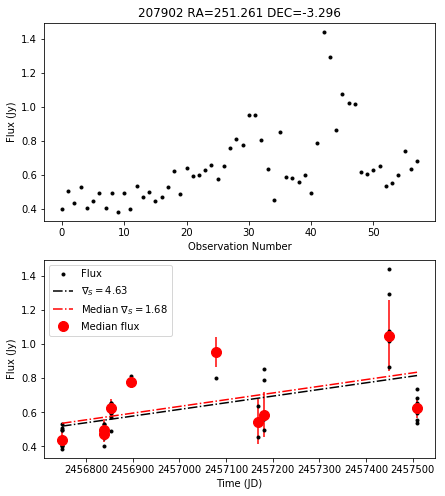

<Figure size 720x864 with 0 Axes>

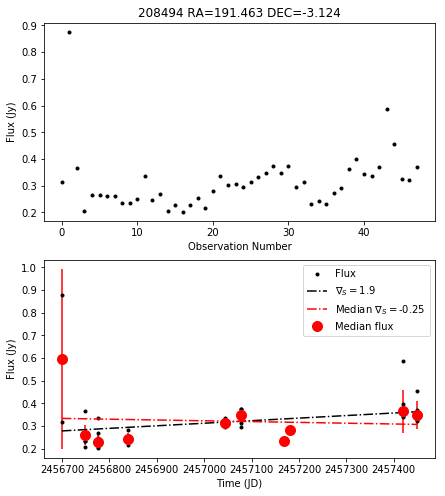

<Figure size 720x864 with 0 Axes>

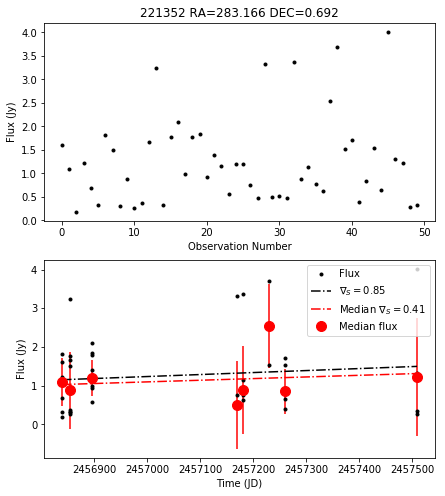

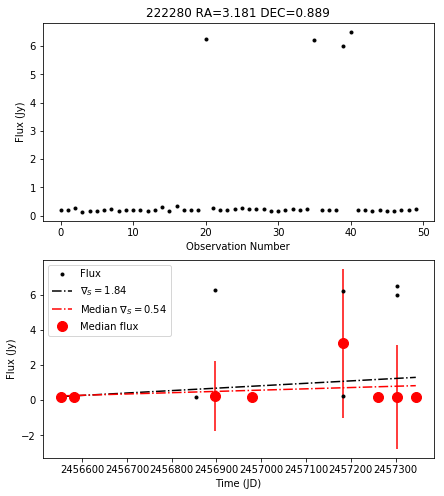

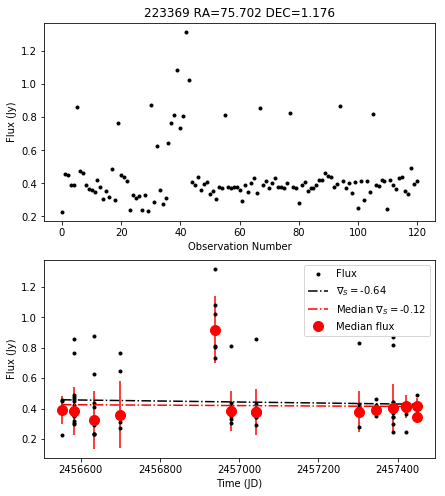

<Figure size 720x864 with 0 Axes>

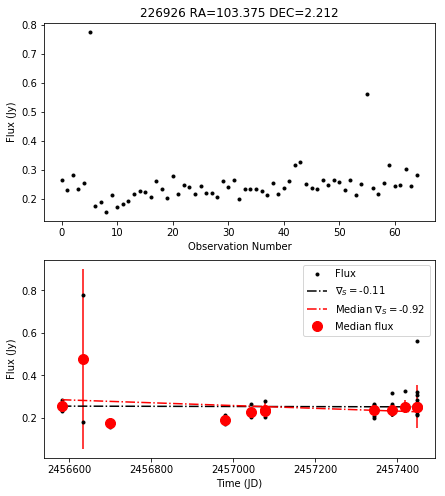

<Figure size 720x864 with 0 Axes>

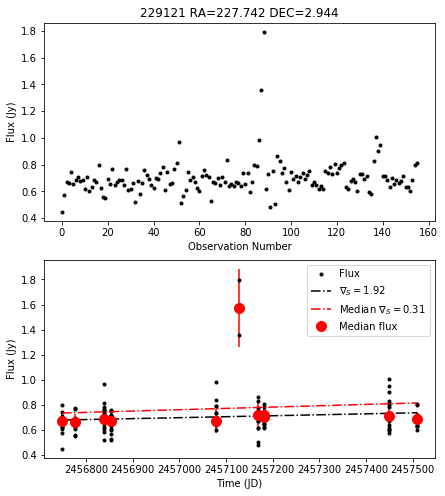

<Figure size 720x864 with 0 Axes>

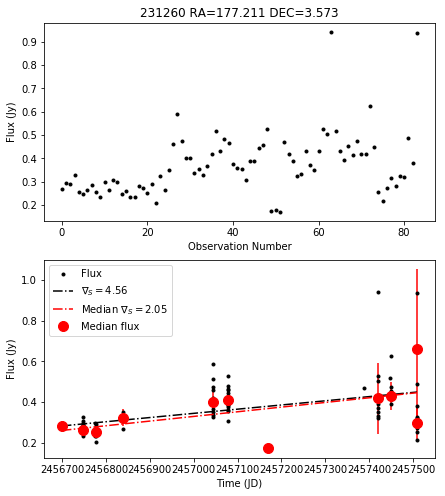

<Figure size 720x864 with 0 Axes>

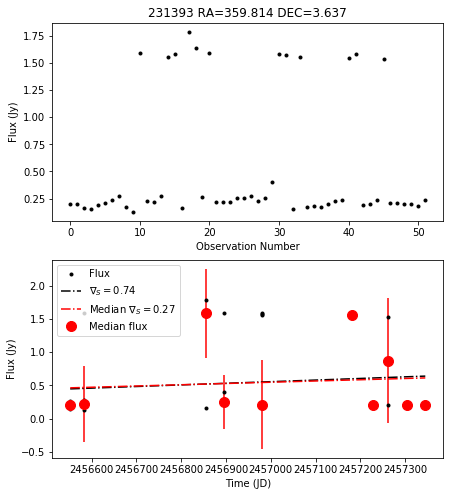

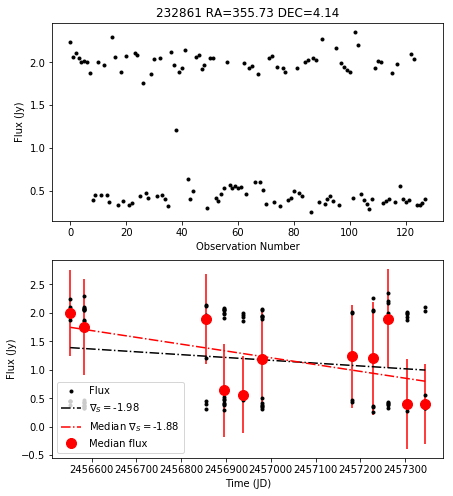

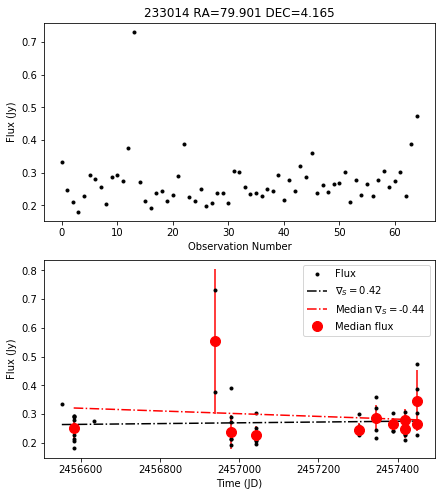

<Figure size 720x864 with 0 Axes>

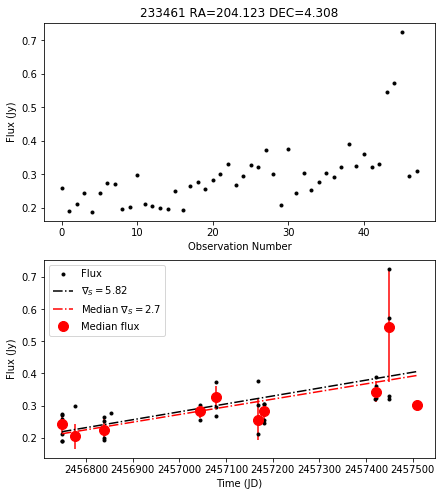

<Figure size 720x864 with 0 Axes>

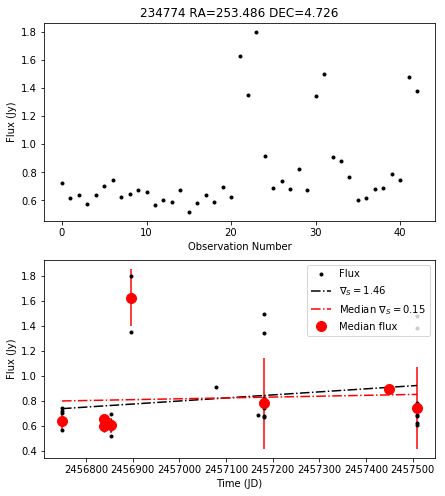

<Figure size 720x864 with 0 Axes>

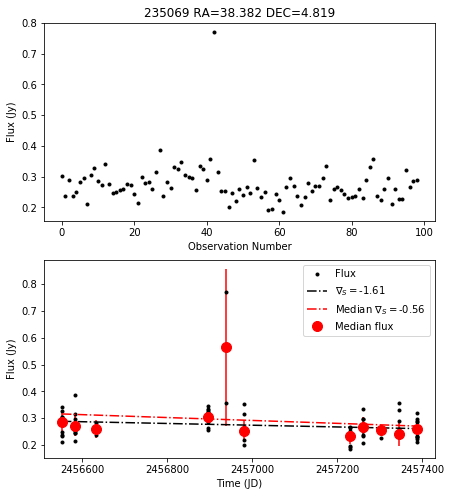

<Figure size 720x864 with 0 Axes>

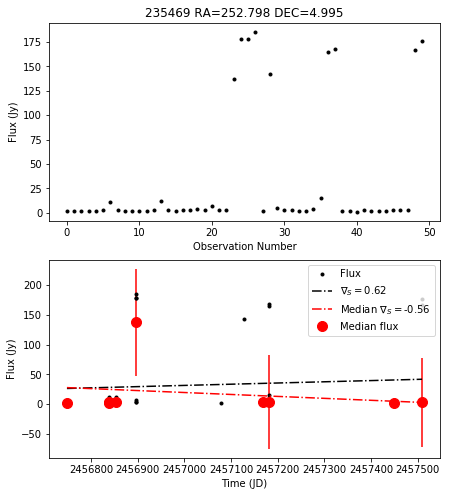

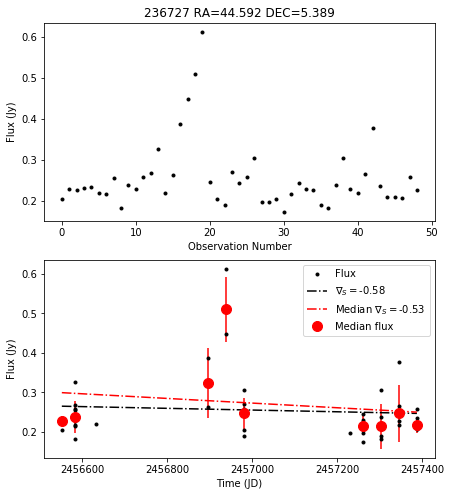

<Figure size 720x864 with 0 Axes>

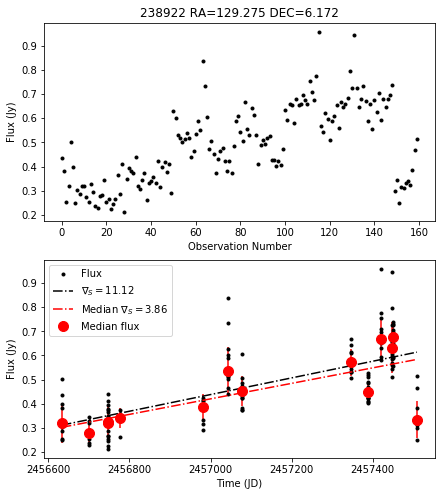

<Figure size 720x864 with 0 Axes>

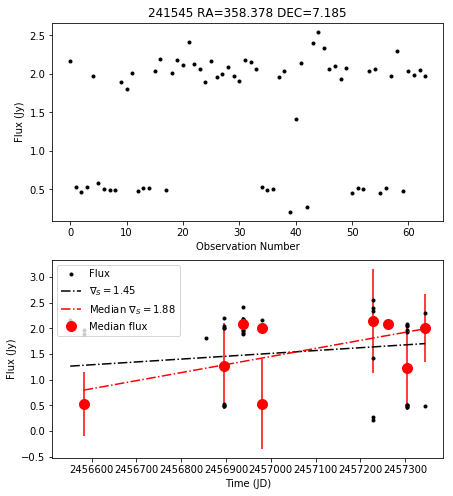

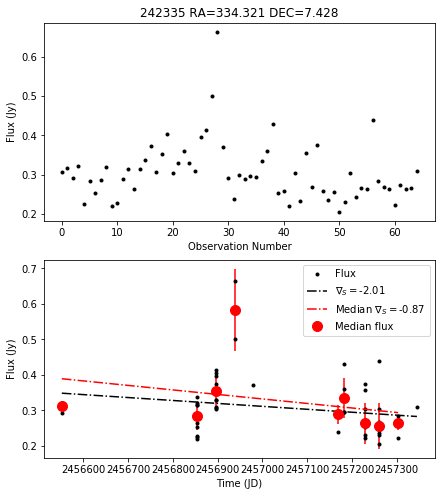

<Figure size 720x864 with 0 Axes>

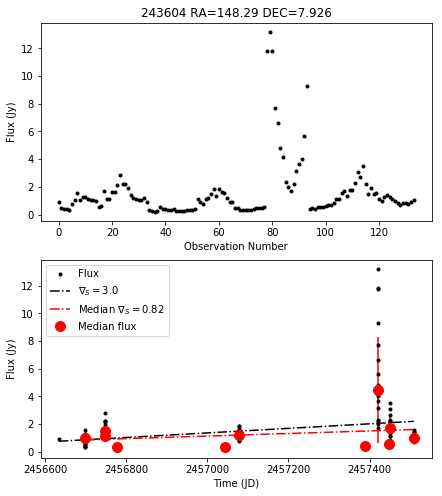

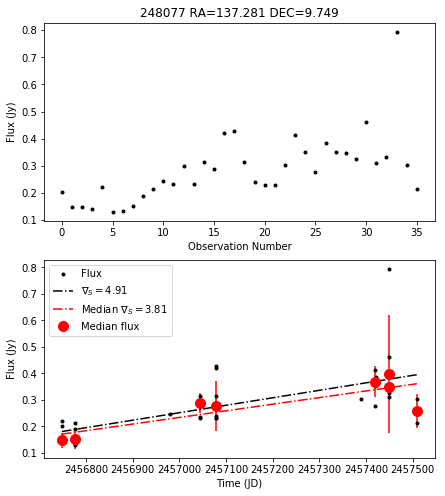

<Figure size 720x864 with 0 Axes>

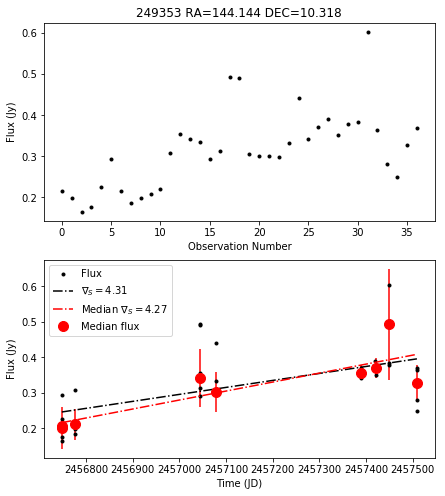

<Figure size 720x864 with 0 Axes>

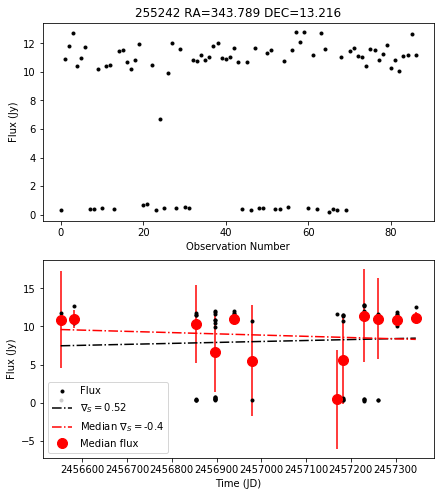

In [147]:
# Make plots of those sources. 
for n in interesting.source_id:
   plot_lc(n)
   plot_n_lc(n)
   get_image(n)

In [172]:
plot_link = []
LC_link = []
avg_link = []
url = []
count = 0
for s in (list(interesting.source_id)):
    plot_link.append("<img src=\'thumbs/"+str(s)+".jpg\'>") 
    LC_link.append("<img src=\'thumbs/"+str(s)+"_LCS.jpg\'>") 
    avg_link.append("<img src=\'thumbs/"+str(s)+"_Avg_LC.jpg\'>") 
    url.append('<a href="http://simbad.u-strasbg.fr/simbad/sim-coo?Coord='+str(interesting.ra.values[count])+'d+'+str(interesting.dec.values[count])+'d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query">Simbad Link</a>')
    count +=1


,raw_peak_flux,image
2322002,29.048921,1088185320_W_bm_1.0_SC_I.fits
2322003,26.779443,1117739592_W_bm_1.0_SC_I.fits
2322004,24.533521,1117738152_W_bm_1.0_SC_I.fits
2322005,24.783970,1117738512_W_bm_1.0_SC_I.fits
2322006,38.298668,1116707256_W_bm_1.0_SC_I.fits
2322007,24.323203,1093095544_W_bm_1.0_SC_I.fits
2322008,29.623930,1093097704_W_bm_1.0_SC_I.fits
2322009,30.215576,1088185680_W_bm_1.0_SC_I.fits
2322010,32.343545,1121876144_W_bm_1.0_SC_I.fits
2322011,24.762314,1089476320_W_bm_1.0_SC_I.fits


In [174]:
interesting['plot_links'] = plot_link
interesting['LC_links'] = LC_link
interesting['avg_links'] = avg_link
interesting['url'] = url

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [175]:
pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,plot_links,LC_links,avg_links,url
2475,2490,9626,203.152823,-62.778506,0.765738,0.303694,39.660271,94,3.983624,0.000438,0.000110,-1074.363164,1.504227,3.560650e-04,0.000237,-874.196992,0.252276,0.697101,36.189312,,,,Simbad Link
2659,2676,10057,141.356216,-62.528659,0.344761,0.101120,29.330620,36,8.899923,0.000300,0.000034,-737.705074,5.960626,3.279945e-04,0.000055,-805.570112,0.110607,0.339858,32.545129,,,,Simbad Link
3265,3289,11643,168.081167,-61.342199,0.848598,0.337037,39.716871,75,6.032429,0.000696,0.000115,-1710.497678,2.617023,5.294130e-04,0.000202,-1300.078987,0.241509,0.759459,31.800188,,,,Simbad Link
3270,3294,11656,201.677521,-61.331384,0.827691,0.411734,49.744936,38,-0.079716,-0.000022,0.000275,54.666834,0.451813,2.003412e-04,0.000443,-491.436920,0.314633,0.792390,39.706788,,,,Simbad Link
3456,3482,12131,243.560256,-61.021059,2.573485,1.978635,76.885424,70,1.129493,0.000947,0.000838,-2323.165422,-0.670967,-1.407931e-03,0.002098,3461.891655,1.738782,2.528826,68.758477,,,,Simbad Link
3513,3539,12278,136.121885,-60.939231,0.309493,0.093794,30.305509,40,6.605067,0.000255,0.000039,-626.452680,2.391868,2.560936e-04,0.000107,-628.946049,0.100277,0.331662,30.234593,,,,Simbad Link
3603,3629,12529,167.995990,-60.654457,1.178310,0.514090,43.629482,45,2.500050,0.000605,0.000242,-1485.111718,3.147428,8.661021e-04,0.000275,-2126.945731,0.373085,1.138644,32.765712,,,,Simbad Link
3695,3721,12775,248.732186,-60.606275,0.489604,0.135700,27.716182,82,3.381805,0.000194,0.000057,-475.696871,1.672818,2.933660e-04,0.000175,-720.304468,0.157356,0.517838,30.387169,,,,Simbad Link
3706,3732,12800,206.582791,-60.372104,3.375753,1.841752,54.558241,146,1.984307,0.001154,0.000582,-2832.082496,2.321899,2.234495e-03,0.000962,-5487.284172,1.088570,3.044044,35.760650,,,,Simbad Link
3734,3760,12871,243.113213,-60.544955,1.253203,0.683640,54.551379,38,1.542736,0.000597,0.000387,-1465.251987,0.415809,3.925210e-04,0.000944,-963.232578,0.691356,1.221891,56.580769,,,,Simbad Link


In [70]:
variable = filtered_raw_data[filtered_raw_data.source_id == 44801]
filtered_raw_data[['raw_peak_flux','image']]

## Location plots

In [ ]:
def write_mod(ra, dec):
    rad = 400
    colour_str = '# color = green'
    f.write('circle('+str(ra)+','+str(dec)+','+str(rad)+'\") '+colour_str)
    f.write('\n')
    
def write_mod_2(ra, dec):
    rad = 450
    colour_str = '# color = red'
    f.write('circle('+str(ra)+','+str(dec)+','+str(rad)+'\") '+colour_str)
    f.write('\n')    

def write_line(ra1, dec1, ra2, dec2):
    times = 1.00
    f.write('line('+str(ra1)+','+str(dec1)+','+str(ra2*times)+','+str(dec2*times)+')')
    f.write('\n')
    
f  = open("close.reg", "w")
f.write('fk5')
f.write('\n')

In [ ]:
close_ra = list(close_source.source_id_ra)
close_dec = list(close_source.source_id_dec)
close_ra_n = list(close_source.n_id1_ra)
close_dec_n = list(close_source.n_id1_dec)
for i in range(len(close_ra)):
    write_mod(close_ra[i], close_dec[i])
    write_mod_2(close_ra_n[i], close_dec_n[i])
    write_line(close_ra[i], close_dec[i],close_ra_n[i], close_dec_n[i])